In [1]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import graph_viz as viz
import logger_creator

import graph_tools
import networkx as nx

def generate_confidence_delegation_graph(n, seed=0):
    """
    Generate a directed graph with a pyramid structure of lots of low confidence nodes, 
    fewer medium confidence nodes, and the fewest high confidence nodes. This simulates a
    scenario where most nodes have low confidence, some have medium, and very few have high confidence
    with a tendency to delegate upwards."""

    if n == 0:
        return nx.DiGraph()

    # Allocate nodes in a pyramid: many low, fewer medium, fewest high confidence
    low_count = int(n * 0.6)
    medium_count = int(n * 0.3)
    high_count = n - low_count - medium_count
    sizes = [low_count, medium_count, high_count]

    # Delegation tendency matrix: rows = from group, cols = to group
    # Higher values for upward delegation
    p = [
        # To:  Low / n  Medium / n  High / n
        [0.4 / n, 1 / n, 1 / n],   # From Low
        [0.1 / n, 0.4 / n, 1 / n],    # From Medium
        [0.1 / n, 0.1 / n, 0.4 / n],   # From High
    ]
    
    G = nx.stochastic_block_model(sizes, p, directed=True, seed=seed)

    return G


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [28]:
# to guage how often cycles appear in these graphs
for seed in range(10):
    i_s = []
    for i in range(100):
        stochastic_block_model_graph = generate_confidence_delegation_graph(i, seed=seed)
        stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
        delegation_graph = graph_tools.prepare_graph(stochastic_block_model_graph.nodes(), stochastic_block_model_graph.edges(), 0.0)
        if "lost" in delegation_graph:
            i_s.append(i)
    if i_s:
        print(f"Seed {seed}: {i_s}")


Seed 0: [59, 77, 90, 91]
Seed 1: [10, 51]
Seed 2: [8, 34, 51]
Seed 3: [30, 66, 75, 76, 87]
Seed 4: [43]
Seed 5: [10, 11]
Seed 6: [30, 83]
Seed 7: [29, 55, 56, 85]
Seed 9: [55]


In [30]:
stochastic_block_model_graph = generate_confidence_delegation_graph(20, seed=1)
stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
delegations_orig = graph_tools.nx_graph_to_dict(stochastic_block_model_graph)

viz.visualize_delegation_graph(delegations_orig)

print(list(nx.strongly_connected_components(stochastic_block_model_graph)))

Parsing the data...Done
Parsing the data...Done


Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


Graph visualization failed because no ports were found or there was another error.
[{'0'}, {'18'}, {'3'}, {'1'}, {'12'}, {'2'}, {'4'}, {'5'}, {'6'}, {'17'}, {'7'}, {'8'}, {'9'}, {'10'}, {'11'}, {'13'}, {'14'}, {'15'}, {'16'}, {'19'}]


No trigger


0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800


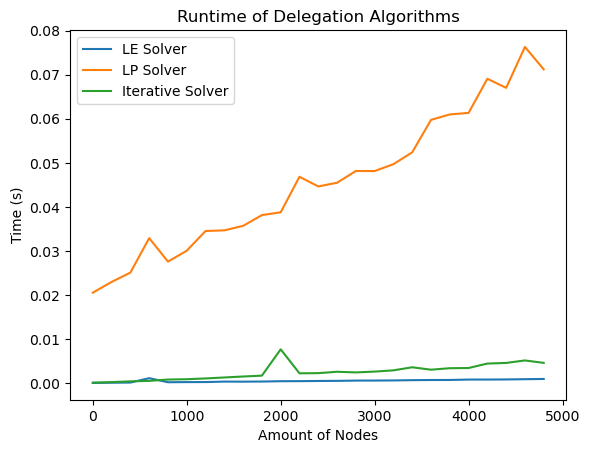

In [16]:
range_x = range(0, 5000, 200)

time_data_le = []
time_data_lp = []
time_data_iterative = []
cycles = []


logger, handler = logger_creator.create_logger("benchmarking")

for num_loops in range(1):
    times_le = []
    times_lp = []
    times_iterative = []

    for num_nodes in range_x:
        print(num_nodes)

        stochastic_block_model_graph = generate_confidence_delegation_graph(num_nodes)
        stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
        delegation_graph = graph_tools.prepare_graph(stochastic_block_model_graph.nodes(), stochastic_block_model_graph.edges(), 0.0)
        nodes = list(delegation_graph)
        delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
        delegations = graph_tools.invert_graph(delegations_orig)

        # Verify the solutions are equal
        powers_le, sinks_le = lp.resolve_delegations(delegations, nodes)
        powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
        powers_iter = iterative.iterate_delegations(delegations, nodes)

        if powers_le != powers_lp:
            logger.error("Powers do not match")
            logger.error(f"LE: {powers_le}")
            logger.error(f"LP: {powers_lp}")
            print("Mismatching powers in LE and LP. Check the log file for details.")
            break

        for node in sinks_le:
            if (powers_lp[node] - powers_iter[node] < 0.01):
                continue
            else: 
                logger.error("Powers do not match")
                logger.error(f"LP: {powers_lp}")
                logger.error(f"Iterative: {powers_iter}")
                print("Mismatching powers in LP and Iterative. Check the log file for details.")
                break

        n = 10
        if 0 <= num_nodes < 500:
            n = 100
        elif 500 <= num_nodes < 2000:
            n = 50

        # LE
        le_model = le.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            le.solve(*le_model)
        end_time = time.time()
        
        times_le.append((end_time - start_time) / n)

        # LP
        lp_model = lp.set_up(delegations, nodes)
        start_time = time.time()
        for _ in range(n):
            lp.solve(*lp_model)
        end_time = time.time()

        times_lp.append((end_time - start_time) / n)
    
        # Iterative
        start_time = time.time()
        for _ in range(n):
            p = iterative.iterate_delegations(delegations, nodes)
        end_time = time.time()

        times_iterative.append((end_time - start_time) / n)


    time_data_le.append(times_le)
    time_data_lp.append(times_lp)
    time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()

x = list(range_x)

plt.clf()

for i in range(len(time_data_lp)):
    plt.plot(x, time_data_le[i], label=f"LE Solver")
    plt.plot(x, time_data_lp[i], label=f"LP Solver") 
    plt.plot(x, time_data_iterative[i], label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtime of Delegation Algorithms")
plt.show()

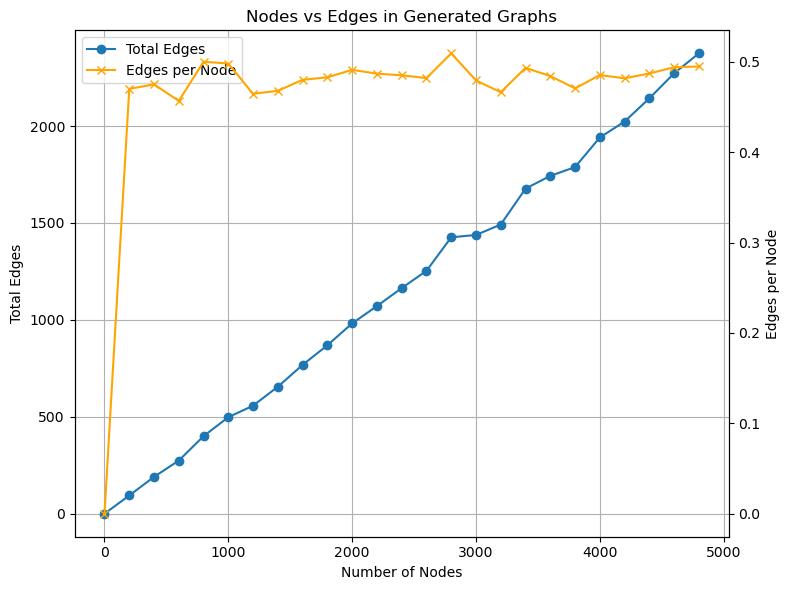

In [24]:
import matplotlib.pyplot as plt
import networkx as nx

def generate_graph(num_nodes):
    stochastic_block_model_graph = generate_confidence_delegation_graph(num_nodes)
    stochastic_block_model_graph = graph_tools.nx_graph_nodes_to_str(stochastic_block_model_graph)
    return graph_tools.prepare_graph(stochastic_block_model_graph.nodes(), stochastic_block_model_graph.edges(), 0.0)

node_counts = []
edge_counts = []
edges_per_node_counts = []

for i in range(0, 5000, 200): 
    G = generate_graph(i)
    node_counts.append(G.number_of_nodes())
    edge_counts.append(G.number_of_edges())
    edges_per_node_counts.append(G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot total edges on the left y-axis
ax1.plot(node_counts, edge_counts, marker='o', label='Total Edges')
ax1.set_xlabel("Number of Nodes")
ax1.set_ylabel("Total Edges")
ax1.tick_params(axis='y')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(node_counts, edges_per_node_counts, marker='x', label='Edges per Node', color='orange')
ax2.set_ylabel("Edges per Node")
ax2.tick_params(axis='y')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Nodes vs Edges in Generated Graphs")
ax1.grid(True)
fig.tight_layout()
plt.show()
